In [1]:
import joblib
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

from multiprocessing import Pool
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from tqdm import tqdm

In [2]:
np.random.seed(42)
warnings.filterwarnings('ignore')

# Carregando os datasets

Abaixo observa-se que ambos os datasets `ind_df` e `conn_df` possuem missing values. Em particular, chama a atenção o fato de que em `conn_df` os missing values concentram-se na variável target, a probabilidade de contaminação.

## conn_df

In [3]:
conn_df = pd.read_csv('../data/raw/conexoes_espec.csv', sep=';')

In [4]:
conn_df

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN
...,...,...,...,...,...
999994,499998,999996,trabalho,visita_rara,NaN
999995,499998,999997,trabalho,visita_rara,NaN
999996,499999,999998,familia,visita_casual,0.451662
999997,499999,999999,familia,visita_rara,0.186973


In [5]:
conn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   V1           999999 non-null  int64  
 1   V2           999999 non-null  int64  
 2   grau         999999 non-null  object 
 3   proximidade  999999 non-null  object 
 4   prob_V1_V2   499999 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 38.1+ MB


In [6]:
conn_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
V1,999999.0,NaN,NaN,NaN,250000.25,144337.495129,1.0,125000.5,250000.0,375000.0,500000.0
V2,999999.0,NaN,NaN,NaN,500001.0,288674.990255,2.0,250001.5,500001.0,750000.5,1000000.0
grau,999999,3,trabalho,333548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proximidade,999999,4,visita_rara,400238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prob_V1_V2,499999.0,NaN,NaN,NaN,0.485162,0.173963,0.074462,0.351677,0.486413,0.61821,0.942245


In [7]:
conn_df['grau'].unique()

array(['trabalho', 'amigos', 'familia'], dtype=object)

In [8]:
conn_df['proximidade'].unique()

array(['visita_frequente', 'visita_rara', 'visita_casual', 'mora_junto'],
      dtype=object)

## ind_df

In [9]:
ind_df = pd.read_csv('../data/raw/individuos_espec.csv', sep=';')

In [10]:
ind_df

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [11]:
ind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   name                       1000000 non-null  int64  
 1   idade                      904063 non-null   float64
 2   estado_civil               949927 non-null   object 
 3   qt_filhos                  971133 non-null   float64
 4   estuda                     959870 non-null   float64
 5   trabalha                   993647 non-null   float64
 6   pratica_esportes           850876 non-null   float64
 7   transporte_mais_utilizado  956967 non-null   object 
 8   IMC                        886130 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 68.7+ MB


In [12]:
ind_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,1000000.0,NaN,NaN,NaN,500000.5,288675.278933,1.0,250000.75,500000.5,750000.25,1000000.0
idade,904063.0,NaN,NaN,NaN,30.008431,10.951566,0.0,22.0,29.0,37.0,124.0
estado_civil,949927,4,solteiro,420637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qt_filhos,971133.0,NaN,NaN,NaN,0.928406,0.997289,0.0,0.0,1.0,1.0,9.0
estuda,959870.0,NaN,NaN,NaN,0.442588,0.496693,0.0,0.0,0.0,1.0,1.0
trabalha,993647.0,NaN,NaN,NaN,0.556739,0.496771,0.0,0.0,1.0,1.0,1.0
pratica_esportes,850876.0,NaN,NaN,NaN,0.599823,0.489934,0.0,0.0,1.0,1.0,1.0
transporte_mais_utilizado,956967,3,publico,574779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMC,886130.0,NaN,NaN,NaN,22.472079,7.073692,4.852828,17.420851,21.4312,26.378197,89.158204


In [13]:
ind_df['estado_civil'].unique()

array(['divorciado', 'casado', 'solteiro', nan, 'viuvo'], dtype=object)

In [14]:
ind_df['transporte_mais_utilizado'].unique()

array(['publico', 'particular', 'taxi', nan], dtype=object)

## Combinando ind_df e conn_df

In [15]:
df_raw = pd.merge(ind_df.rename(columns=lambda x: x + '_V2'),
                  conn_df, 
                  how='right',
                  left_on='name_V2', 
                  right_on='V2')
df_raw = pd.merge(ind_df.rename(columns=lambda x: x + '_V1'),
                  df_raw, 
                  how='right',
                  left_on='name_V1', 
                  right_on='V1')
df_raw = df_raw.drop(['V1', 'V2'], axis=1)
df_raw

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,NaN,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,NaN,familia,visita_casual,0.451662
999997,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


# Utils

Modelos de classificação do scikit-learn não aceitam probabilidade como variável target, portanto a estratégia adotada para treinar modelos e estimar as probabilidades de contaminação foi:
1. aplicar a transformação logit (inversa da função sigmoide) às probabilidades, a fim de que possam assumir qualquer valor real;
2. treinar modelos de regressão utilizando os logits das probabilidades;
3. aplicar a transformação sigmoide aos resultados obtidos, e assim recuperar o target em termos de probabilidades; e
4. comparar a performance dos modelos usando a função de perda cross-entropy.

In [16]:
def logit(p):
    return np.log(p / (1-p))

def sigmoid(y):
    ey = np.exp(y)
    return ey / (1+ey)

def cross_entropy_loss(y_true, y_pred):
    p, q = sigmoid(y_true), sigmoid(y_pred)
    return -(p*np.log(q) + (1-p)*np.log(1-q)).mean()

# Modelos

In [17]:
categorical_cols = ['estado_civil_V1', 'estado_civil_V2',
                    'transporte_mais_utilizado_V1', 'transporte_mais_utilizado_V2',
                    'grau', 'proximidade']

boolean_cols = ['estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
                'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

numerical_cols = ['idade_V1', 'qt_filhos_V1', 'IMC_V1',
                  'idade_V2', 'qt_filhos_V2', 'IMC_V2']

cols_to_drop = ['name_V1', 'name_V2', 'prob_V1_V2']

## Modelo Baseline

A fim de se obter rapidamente um modelo baseline cuja performance servirá como benchmark para os demais modelos, os missing values foram imputados da forma mais básica possível, de acordo com as seguintes estratégias:
1. variáveis categóricas $\leftarrow$ moda
2. variáveis booleanas $\leftarrow$ média
3. variáveis numéricas $\leftarrow$ mediana.

Para os demais modelos, foram testadas diferentes estratégias para imputar os missing values em `ind_df`. Já no caso de `conn_df`, foi utilizada sempre a mesma estratégia de imputar os missing values com as predições do modelo KNN Regressor (aplicado a uma versão do dataset original com a dimensionalidade reduzida pelo método PCA, buscando preservar cerca de 90% da variância explicada pelas features originais), treinado em um dataset com dados completos. Por fim, o target foi, em todos os casos, estimado utilizando-se a Regressão Linear a fim de que a comparabilidade das estratégias de imputação fosse preservada.


A única exceção a estas regras foi o último modelo, LightGBM Regressor, por se tratar de um que a presença de missing values entre os dados não representa um problema.

In [18]:
df_bl = df_raw.copy(deep=True)

df_bl['prob_V1_V2'].fillna(df_bl['prob_V1_V2'].median(skipna=True), inplace=True)

In [19]:
X_bl = df_bl.drop(cols_to_drop, axis=1)
y_bl = df_bl['prob_V1_V2']

X_bl_train_, X_bl_test_, y_bl_train, y_bl_test = train_test_split(X_bl,
                                                                  logit(y_bl),
                                                                  test_size=0.4,
                                                                  random_state=42)

In [20]:
X_bl_train, X_bl_test = X_bl_train_.copy(deep=True), X_bl_test_.copy(deep=True)

mode_imp = SimpleImputer(strategy='most_frequent')
mean_imp = SimpleImputer(strategy='mean')
median_imp = SimpleImputer(strategy='median')

X_bl_train[categorical_cols] = mode_imp.fit_transform(X_bl_train_[categorical_cols])
X_bl_train[boolean_cols] = mean_imp.fit_transform(X_bl_train_[boolean_cols])
X_bl_train[numerical_cols] = median_imp.fit_transform(X_bl_train_[numerical_cols])

X_bl_test[categorical_cols] = mode_imp.transform(X_bl_test_[categorical_cols])
X_bl_test[boolean_cols] = mean_imp.transform(X_bl_test_[boolean_cols])
X_bl_test[numerical_cols] = median_imp.transform(X_bl_test_[numerical_cols])

In [21]:
one_enc = OneHotEncoder(drop='first', sparse=False)
one_enc.fit(X_bl_train[categorical_cols])

one_hot_cols = one_enc.get_feature_names(categorical_cols)

X_bl_train[one_hot_cols] = one_enc.transform(X_bl_train[categorical_cols])
X_bl_train.drop(categorical_cols, axis=1, inplace=True)

X_bl_test[one_hot_cols] = one_enc.transform(X_bl_test[categorical_cols])
X_bl_test.drop(categorical_cols, axis=1, inplace=True)

In [22]:
bl_model = LinearRegression().fit(X_bl_train, y_bl_train)

In [23]:
train_loss = cross_entropy_loss(y_bl_train, bl_model.predict(X_bl_train))
test_loss = cross_entropy_loss(y_bl_test, bl_model.predict(X_bl_test))

print('baseline train loss:', train_loss)
print('baseline test loss:', test_loss)

baseline train loss: 0.684272325646911
baseline test loss: 0.6842074405738243


## Modelo 1

A imputação dos missing values em `ind_df` foi feita utilizando o KNNImputer, um método computacionalmente bastante custoso. Em se tratando de um dataset com 1M de linhas, este processo teve uma duração média de 8 horas e 30 minutos. Por outro lado, a imputação do target em `conn_df` foi bem rápida, uma vez que a dimensionalidade do dataset foi reduzida de 31 features para 15 após aplicação do PCA.

In [24]:
ind_df_1 = ind_df.copy(deep=True)

In [25]:
ind_df_1

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [26]:
cat_to_values = {'divorciado': 0,
                 'casado': 1,
                 'solteiro': 2,
                 'viuvo': 3,
                 'publico': 4,
                 'particular': 5,
                 'taxi': 6}

ind_df_1_ = ind_df_1.replace(cat_to_values)

scaler = MinMaxScaler()
ind_df_1_ = scaler.fit_transform(ind_df_1_.drop('name', axis=1))

In [27]:
# %%time

# knn_imp = KNNImputer(weights='distance')

# ind_df_1_ = knn_imp.fit_transform(ind_df_1_)

In [28]:
# ind_df_1_ = pd.DataFrame(scaler.inverse_transform(ind_df_1_), columns=ind_df_1_.columns)
# ind_df_1 = pd.concat([ind_df_1['name'], ind_df_1_], axis=1)

In [29]:
# cols = ['estado_civil', 'transporte_mais_utilizado']
# values_to_cat = {v: k for (k, v) in cat_to_values.items()}
# ind_df_1[cols] = ind_df_1[cols].round().replace(values_to_cat)

In [30]:
ind_df_1 = pd.read_csv('../data/processed/ind_df_filled_knn.csv')

ind_df_1

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,16.856449
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [31]:
conn_df

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN
...,...,...,...,...,...
999994,499998,999996,trabalho,visita_rara,NaN
999995,499998,999997,trabalho,visita_rara,NaN
999996,499999,999998,familia,visita_casual,0.451662
999997,499999,999999,familia,visita_rara,0.186973


In [32]:
df_1 = pd.merge(ind_df_1.rename(columns=lambda x: x + '_V2'),
                conn_df, 
                how='right',
                left_on='name_V2', 
                right_on='V2')
df_1 = pd.merge(ind_df_1.rename(columns=lambda x: x + '_V1'),
                df_1, 
                how='right',
                left_on='name_V1', 
                right_on='V1')
df_1 = df_1.drop(['V1', 'V2'], axis=1)
df_1

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,casado,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,16.856449,familia,visita_casual,0.451662
999997,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


In [33]:
scaler = MinMaxScaler()
pca = PCA(n_components=0.9, random_state=42)

df_1_ = pd.get_dummies(df_1.drop(cols_to_drop, axis=1), drop_first=True)
df_1_ = pca.fit_transform(scaler.fit_transform(df_1_))

pca_comps = [f'pc_{n+1}' for n in range(df_1_.shape[1])]
df_1_ = pd.DataFrame(scaler.fit_transform(df_1_), columns=pca_comps)

pd.Series(pca.explained_variance_ratio_, index=pca_comps).cumsum()

pc_1     0.086315
pc_2     0.168872
pc_3     0.247949
pc_4     0.326829
pc_5     0.387379
pc_6     0.447829
pc_7     0.508215
pc_8     0.568447
pc_9     0.625686
pc_10    0.679968
pc_11    0.734119
pc_12    0.787714
pc_13    0.841276
pc_14    0.872330
pc_15    0.903357
dtype: float64

In [34]:
df_1_ = df_1_.loc[:, :pca_comps[-1]]
df_1_['prob_V1_V2'] = df_1['prob_V1_V2']

df_1_

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,prob_V1_V2
0,0.653480,0.978062,0.498888,0.586829,0.450084,0.124045,0.413572,0.698691,0.992547,0.208060,0.341915,0.117494,0.213687,0.194833,0.364329,0.589462
1,0.015578,0.983627,0.331448,0.392191,0.146284,0.229305,0.702338,0.583029,0.249563,0.186896,0.332452,0.085130,0.219747,0.284321,0.222317,0.708465
2,0.982948,0.980343,0.498266,0.597786,0.428147,0.337495,0.255632,0.597697,0.046075,0.940550,0.395555,0.861075,0.120225,0.511721,0.570669,NaN
3,0.008505,0.987550,0.229662,0.292308,0.465730,0.342809,0.249001,0.643342,0.223280,0.678965,0.265058,0.062450,0.171574,0.594902,0.440663,0.638842
4,0.566265,0.496067,0.786290,0.520869,0.687914,0.477644,0.366519,0.255958,0.400936,0.686252,0.179619,0.839795,0.160781,0.381837,0.469448,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,0.021601,0.974196,0.599403,0.710349,0.385815,0.312614,0.235336,0.407990,0.216311,0.283496,0.780356,0.178889,0.834128,0.521004,0.559124,NaN
999995,0.020955,0.974755,0.601013,0.708428,0.155606,0.479019,0.512950,0.431922,0.216957,0.279284,0.781477,0.155176,0.841583,0.520748,0.557757,NaN
999996,0.987836,0.013022,0.578336,0.683063,0.897644,0.434051,0.499722,0.576376,0.064234,0.463309,0.131524,0.044837,0.936712,0.726113,0.236927,0.451662
999997,0.018214,0.013243,0.501543,0.594012,0.822749,0.397972,0.495630,0.446773,0.215903,0.965429,0.496460,0.090819,0.802927,0.513344,0.568878,0.186973


In [35]:
df_1_.describe().T

,count,mean,std,min,25%,50%,75%,max
pc_1,999999.0,0.487136,0.408548,0.000000,0.021075,0.571158,0.974656,1.000000
pc_2,999999.0,0.499554,0.395057,0.000000,0.021109,0.499193,0.978008,1.000000
pc_3,999999.0,0.499670,0.204613,0.000000,0.353328,0.500663,0.635035,1.000000
pc_4,999999.0,0.489310,0.205700,0.000000,0.328125,0.499037,0.626108,1.000000
pc_5,999999.0,0.467670,0.213161,0.000000,0.305529,0.464711,0.619285,1.000000
pc_6,999999.0,0.487157,0.170445,0.000000,0.364730,0.486413,0.605837,1.000000
pc_7,999999.0,0.395239,0.203290,0.000000,0.248246,0.396399,0.533261,1.000000
pc_8,999999.0,0.466763,0.174713,0.000000,0.341857,0.468248,0.593560,1.000000
pc_9,999999.0,0.328804,0.327034,0.000000,0.060367,0.213232,0.413298,1.000000
pc_10,999999.0,0.491858,0.215099,0.000000,0.300925,0.490406,0.673899,1.000000


In [36]:
mask = df_1_['prob_V1_V2'].isna()
X_1_isna = df_1_.loc[mask].drop('prob_V1_V2', axis=1)
X_1_notna = df_1_.loc[~mask].drop('prob_V1_V2', axis=1)
y_1_notna = logit(df_1_.loc[~mask, 'prob_V1_V2'])

In [37]:
knn_reg_imp = KNeighborsRegressor(weights='distance', n_jobs=-1)

knn_reg_imp.fit(X_1_notna, y_1_notna)

df_1_.loc[mask, 'prob_V1_V2'] = sigmoid(knn_reg_imp.predict(X_1_isna))

In [38]:
df_1['prob_V1_V2'] = df_1_['prob_V1_V2']

X_1_, y_1 = df_1.drop(cols_to_drop, axis=1), df_1['prob_V1_V2']
X_1 = pd.get_dummies(X_1_, drop_first=True)

In [39]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1,
                                                            logit(y_1),
                                                            test_size=0.4,
                                                            random_state=42)

In [40]:
lr_1_model = LinearRegression().fit(X_1_train, y_1_train)

In [41]:
train_loss = cross_entropy_loss(y_1_train, lr_1_model.predict(X_1_train))
test_loss = cross_entropy_loss(y_1_test, lr_1_model.predict(X_1_test))

print('lr_1 train loss:', train_loss)
print('lr_1 test loss:', test_loss)

lr_1 train loss: 0.6579712179892695
lr_1 test loss: 0.6580647215588603


## Modelo 2

Observamos uma melhora significativa na performance do Modelo 1 em relação ao do Baseline, no entanto a um custo de mais de 8 horas de treinamento. Para a imputação dos missing values em `ind_df` no Modelo 2, tentamos então realizá-la utilizando EDA, e tentando encontrar padrões e correspondências entre os dados.

In [42]:
ind_df_2 = ind_df.copy(deep=True)

In [43]:
ind_df_2

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [44]:
ind_df_2.isna().mean().sort_values()

name                         0.000000
trabalha                     0.006353
qt_filhos                    0.028867
estuda                       0.040130
transporte_mais_utilizado    0.043033
estado_civil                 0.050073
idade                        0.095937
IMC                          0.113870
pratica_esportes             0.149124
dtype: float64

In [45]:
ind_df_2.corr().round(3)

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
name,1.000,-0.001,0.000,-0.001,0.001,-0.000,0.001
idade,-0.001,1.000,0.116,-0.139,0.137,0.001,-0.000
qt_filhos,0.000,0.116,1.000,-0.080,0.079,-0.001,-0.000
estuda,-0.001,-0.139,-0.080,1.000,-0.096,-0.000,0.000
trabalha,0.001,0.137,0.079,-0.096,1.000,0.001,-0.001
pratica_esportes,-0.000,0.001,-0.001,-0.000,0.001,1.000,-0.001
IMC,0.001,-0.000,-0.000,0.000,-0.001,-0.001,1.000


Uma observação interessante acima é a correlação praticamente nula entre as variáveis `pratica_esportes`, `IMC` e as demais.

In [46]:
ind_df_2['qt_filhos'].value_counts(normalize=True)

0.0    0.413333
1.0    0.341031
2.0    0.171049
3.0    0.057057
4.0    0.014179
5.0    0.002797
6.0    0.000490
7.0    0.000055
8.0    0.000009
9.0    0.000001
Name: qt_filhos, dtype: float64

Por conta do baixo volume de observações com `qt_filhos > 1`, adotei como estratégia bucketizar todas essas observações. Assim, o número de categorias em `qt_filhos` caiu para 3, mas cada uma com um volume representativo de observações.

In [47]:
ind_df_2.loc[ind_df_2['qt_filhos'] > 1, 'qt_filhos'] = 2
ind_df_2['qt_filhos'].value_counts(normalize=True)

0.0    0.413333
1.0    0.341031
2.0    0.245637
Name: qt_filhos, dtype: float64

In [48]:
ind_df_2['estuda'].value_counts(normalize=True)

0.0    0.557412
1.0    0.442588
Name: estuda, dtype: float64

In [49]:
ind_df_2['trabalha'].value_counts(normalize=True)

1.0    0.556739
0.0    0.443261
Name: trabalha, dtype: float64

### EDA `ind_df`

#### `idade`

Começamos analisando como `idade` se relaciona com `estado_civil`, `qt_filhos`, `estuda` e `trabalha`. Não seria nenhum absurdo supor que pessoas mais jovens tendem a serem solteiras, a não ter filhos, a estudarem e a não trabalharem. E como vemos abaixo, os dados corroboram essas hipóteses.

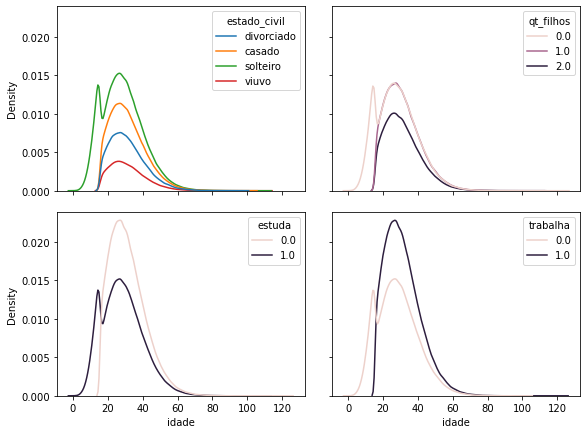

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
fig.tight_layout()

sns.kdeplot(x='idade', hue='estado_civil', data=ind_df_2, ax=ax[0, 0])
sns.kdeplot(x='idade', hue='qt_filhos', data=ind_df_2, ax=ax[0, 1])
sns.kdeplot(x='idade', hue='estuda', data=ind_df_2, ax=ax[1, 0])
sns.kdeplot(x='idade', hue='trabalha', data=ind_df_2, ax=ax[1, 1]);

De fato, vemos nos gráficos acima um padrão peculiar quando a idade é cerca de 16 anos, o que poderia talvez sugerir a existência de duas distribuições distintas dentro dessa população. Por conta disso, criamos uma nova variável chamada `idade_16mais` em que segmentamos as pessoas com menos de, e com mais de, 16 anos.

In [51]:
ind_df_2['idade_16mais'] = np.nan
ind_df_2.loc[ind_df_2['idade'] >= 16, 'idade_16mais'] = True
ind_df_2.loc[ind_df_2['idade'] < 16, 'idade_16mais'] = False

cols = ['estado_civil', 'qt_filhos', 'estuda', 'trabalha']

for c in cols:
    tmp = (ind_df_2
           .groupby('idade_16mais')[c]
           .value_counts(normalize=True)
           .mul(100)
           .rename('pct')
           .reset_index())
    display(tmp)

,idade_16mais,estado_civil,pct
0,False,solteiro,100.000000
1,True,solteiro,39.995511
2,True,casado,30.026507
3,True,divorciado,19.977881
4,True,viuvo,10.000100


,idade_16mais,qt_filhos,pct
0,False,0.0,100.000000
1,True,0.0,36.794654
2,True,1.0,36.770860
3,True,2.0,26.434487


,idade_16mais,estuda,pct
0,False,1.0,100.00000
1,True,0.0,60.02621
2,True,1.0,39.97379


,idade_16mais,trabalha,pct
0,False,0.0,100.000000
1,True,1.0,59.959506
2,True,0.0,40.040494


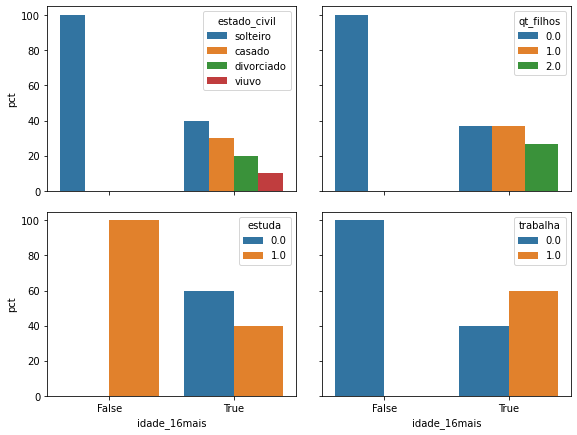

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
fig.tight_layout()

cols = ['estado_civil', 'qt_filhos', 'estuda', 'trabalha']

for n, c in enumerate(cols):
    tmp = (ind_df_2
           .groupby('idade_16mais')[c]
           .value_counts(normalize=True)
           .mul(100)
           .rename('pct')
           .reset_index())
    
    sns.barplot(x='idade_16mais', y='pct', hue=c, data=tmp, ax=ax[n//2, n%2])

ax[0, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('');

In [53]:
(ind_df_2
 .loc[ind_df_2['idade_16mais'] == False]
 .corr()
 .dropna(axis=0, how='all')
 .dropna(axis=1, how='all')
 .round(3))

,name,idade,pratica_esportes,IMC
name,1.000,-0.003,0.003,-0.002
idade,-0.003,1.000,0.004,0.003
pratica_esportes,0.003,0.004,1.000,0.003
IMC,-0.002,0.003,0.003,1.000


In [54]:
(ind_df_2
 .loc[ind_df_2['idade_16mais'] == True]
 .corr()
 .dropna(axis=0, how='all')
 .dropna(axis=1, how='all')
 .round(3))

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
name,1.000,-0.001,0.000,0.000,-0.000,-0.000,0.001
idade,-0.001,1.000,0.001,-0.001,-0.001,0.000,0.000
qt_filhos,0.000,0.001,1.000,0.000,-0.001,-0.001,-0.000
estuda,0.000,-0.001,0.000,1.000,-0.000,0.000,-0.000
trabalha,-0.000,-0.001,-0.001,-0.000,1.000,0.001,0.000
pratica_esportes,-0.000,0.000,-0.001,0.000,0.001,1.000,-0.002
IMC,0.001,0.000,-0.000,-0.000,0.000,-0.002,1.000


Os dados acima suportam as nossas hipóteses iniciais e nos leva a sugerir a seguinte estratégia para imputar os missing values em `idade`:

1. se `estado_civl = solteiro`, `qt_filhos = 0`, `estuda = 1` e `trabalha = 0`, então `idade` é preenchida com amostras aleatórias dos próprios dados observados e vindos do subgrupo de pessoas com até 16 anos;
2. caso contrário, a restrição da idade é retirada e a imputação de `idade` é feita utilizando-se uma amostragem aleatória de todos os dados observados.

Essa estratégia é implementada abaixo de forma iterativa até que `idade` esteja completa.

In [55]:
ind_df_2['idade'].describe().T

count    904063.000000
mean         30.008431
std          10.951566
min           0.000000
25%          22.000000
50%          29.000000
75%          37.000000
max         124.000000
Name: idade, dtype: float64

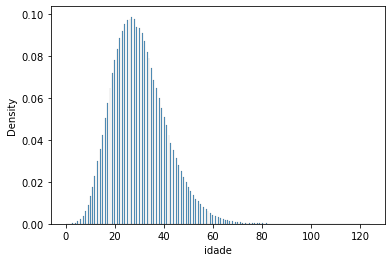

In [56]:
sns.histplot(data=ind_df_2, x='idade', stat='density', bins=320);

In [57]:
def impute_idade(df, impute_below, below_conds, idade_thresh=16, col_name='idade'):
    missing_mask = df[col_name].isna()
    samples = df.loc[~missing_mask, col_name].sample(n=missing_mask.sum())
    
    samples_mask = (samples < idade_thresh) if impute_below else (samples >= idade_thresh)
    below_mask = (df[below_conds.keys()] == below_conds.values()).all(axis=1)
    impute_mask = below_mask if impute_below else ~below_mask
    
    samples_idx = samples[samples_mask].index
    check_samples_idx = impute_mask.rename('valid').to_frame().query('valid == True').index
    valid_samples_idx = samples_idx[samples_idx.isin(check_samples_idx)]
    
    impute_missing_mask = impute_mask & missing_mask
    impute_missing_idx = (impute_missing_mask
                          .rename('impute_missing')
                          .to_frame()
                          .query('impute_missing == True')
                          .index)

    if len(valid_samples_idx) < len(impute_missing_idx):
        impute_missing_idx = (impute_missing_idx
                              .to_series(index=range(len(impute_missing_idx)))
                              .sample(n=len(valid_samples_idx))
                              .values)
    else:
        valid_samples_idx = (valid_samples_idx
                             .to_series(index=range(len(valid_samples_idx)))
                             .sample(n=len(impute_missing_idx))
                             .values)
    
    df.loc[impute_missing_idx, col_name] = samples[valid_samples_idx].values
    
    return df

In [58]:
conds_ate16 = dict(zip(cols, ['solteiro', 0, 1, 0]))
mask = ind_df_2['idade'].isna()

while mask.sum() > 0:
    
    ind_df_2 = impute_idade(ind_df_2,
                            impute_below=True,
                            below_conds=conds_ate16)
    ind_df_2 = impute_idade(ind_df_2,
                            impute_below=False,
                            below_conds=conds_ate16)
    
    if ind_df_2['idade'].isna().sum() < mask.sum():
        print('>', end='')
    else:
        print('.', end='')
        
    mask = ind_df_2['idade'].isna()
    
ind_df_2.loc[ind_df_2['idade'] >= 16, 'idade_16mais'] = True
ind_df_2.loc[ind_df_2['idade'] < 16, 'idade_16mais'] = False

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>.>>>>>.>>>.>>.>.>...>......>>...>.......................................>

In [59]:
ind_df_2['idade'].describe().T

count    1000000.000000
mean          29.994734
std           10.963111
min            0.000000
25%           22.000000
50%           29.000000
75%           37.000000
max          124.000000
Name: idade, dtype: float64

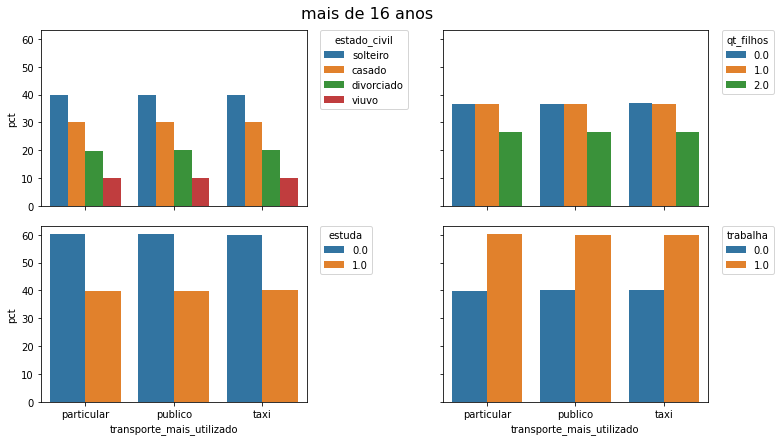

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
fig.tight_layout(w_pad=12)
fig.subplots_adjust(top=0.925)
fig.suptitle('mais de 16 anos', fontsize=16)

cols = ['estado_civil', 'qt_filhos', 'estuda', 'trabalha']

for n, c in enumerate(cols):
    tmp = (ind_df_2
           .loc[ind_df_2['idade_16mais']]
           .groupby('transporte_mais_utilizado')[c]
           .value_counts(normalize=True)
           .rename('pct')
           .mul(100)
           .reset_index())
    sns.barplot(x='transporte_mais_utilizado', y='pct', hue=c, data=tmp, ax=ax[n//2, n%2])
    ax[n//2, n%2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title=c)
    
ax[0, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('');

Tendo em vista todos os resultados acima, imputamos os missing values em `estado_civil`, `qt_filhos`, `estuda` e `trabalha` de acordo com as seguintes regras:
1. se `idade < 16`, então `estado_civil, qt_filhos, estuda, trabalha` $\leftarrow$ `solteiro, 0, 1, 0`;
2. caso contrário, preenchemos com o valor esperado das observações em que `idade > 15` para as variáveis numéricas, e para `estado_civil`, imputamos os missing values com uma nova categoria apelidada de `outros`, dado o volume significativo destes;
3. no caso especial da variável `trabalha`, temos ainda uma informação adicional vinda da variável `grau` em `conn_df` que nos permite imputar com certeza missing values de observações em que `grau = trabalho`.

In [61]:
ind_df_2.loc[ind_df_2['idade_16mais'], 'estado_civil'].value_counts(normalize=True)

solteiro      0.399142
casado        0.300866
divorciado    0.199859
viuvo         0.100133
Name: estado_civil, dtype: float64

In [62]:
mask = ind_df_2['idade_16mais']

ind_df_2.loc[~mask & ind_df_2['estado_civil'].isna(), 'estado_civil'] = 'solteiro'
ind_df_2.loc[~mask & ind_df_2['qt_filhos'].isna(), 'qt_filhos'] = 0
ind_df_2.loc[~mask & ind_df_2['estuda'].isna(), 'estuda'] = 1
ind_df_2.loc[~mask & ind_df_2['trabalha'].isna(), 'trabalha'] = 0

names = np.append(conn_df.loc[conn_df['grau'] == 'trabalho', 'V1'].unique(),
                  conn_df.loc[conn_df['grau'] == 'trabalho', 'V2'].unique())
ind_df_2.loc[mask & ind_df_2.index.isin(names), 'trabalha'] = 1

ind_df_2.loc[mask & ind_df_2['estado_civil'].isna(), 'estado_civil'] = 'outros'
for c in ['qt_filhos', 'estuda', 'trabalha']:
    pct_df = ind_df_2.loc[mask, c].value_counts(normalize=True)
    ind_df_2.loc[mask & ind_df_2[c].isna(), c] = sum(pct_df.index*pct_df.values)

#### `transporte_mais_utilizado`

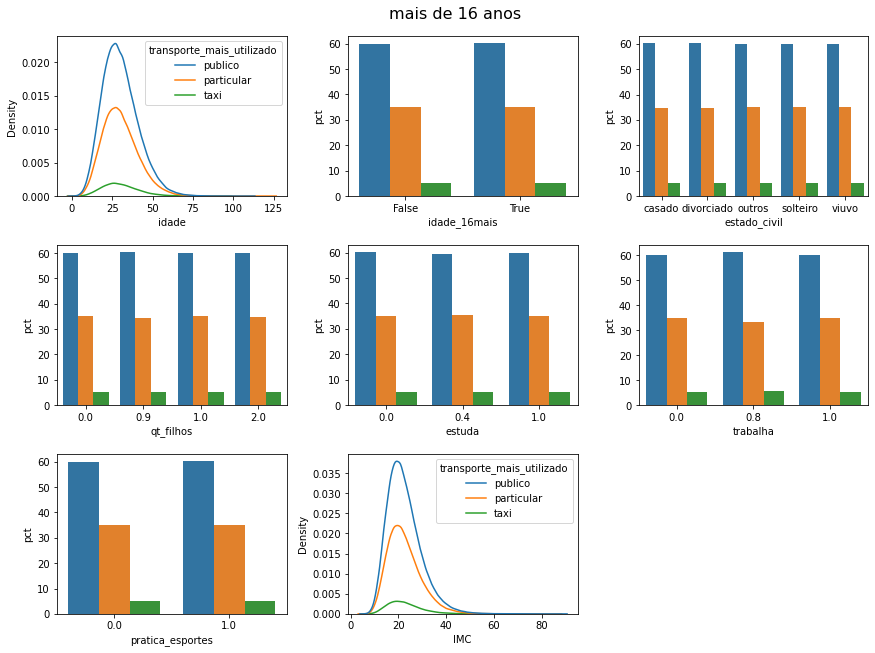

In [63]:
fig, ax = plt.subplots(3, 3, figsize=(12, 9))
fig.tight_layout(w_pad=3, h_pad=3)
fig.subplots_adjust(top=0.935)
fig.suptitle('mais de 16 anos', fontsize=16)

sns.kdeplot(x='idade', hue='transporte_mais_utilizado', data=ind_df_2, ax=ax[0, 0])

cols = ['idade_16mais', 'estado_civil', 'qt_filhos', 'estuda', 'trabalha', 'pratica_esportes']
for n, c in enumerate(cols, start=1):
    tmp = (ind_df_2
           .groupby(c)['transporte_mais_utilizado']
           .value_counts(normalize=True)
           .rename('pct')
           .mul(100)
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='transporte_mais_utilizado', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in sorted(tmp[c].unique())])
    ax[n//3, n%3].get_legend().remove()

sns.kdeplot(x='IMC', hue='transporte_mais_utilizado', data=ind_df_2, ax=ax[2, 1])

fig.delaxes(ax[2, 2]);

Como vemos acima, as demais variáveis não nos dão pistas de uma boa forma de imputar missing values em `transporte_mais_utilizado`. Portanto, dado o volume significativo de missing values nesta variável, equivalente à categoria `taxi`, eu optei por criar uma nova categoria apelidada de `outros` pra preencher estes valores.

In [64]:
ind_df_2['transporte_mais_utilizado'].value_counts(normalize=True)

publico       0.600626
particular    0.349111
taxi          0.050263
Name: transporte_mais_utilizado, dtype: float64

In [65]:
ind_df_2['transporte_mais_utilizado'].fillna('outros', inplace=True)

#### `pratica_esportes`

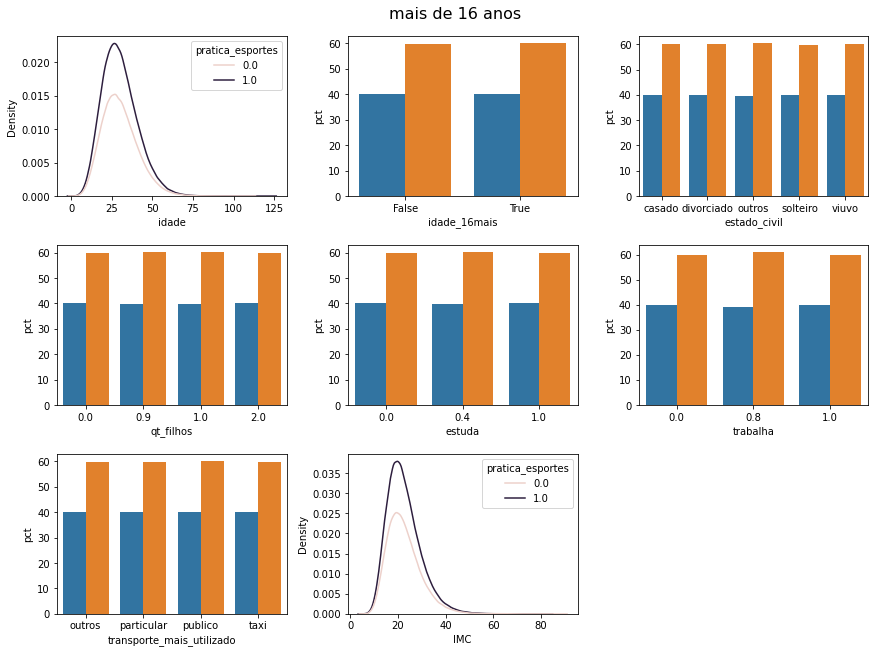

In [66]:
fig, ax = plt.subplots(3, 3, figsize=(12, 9))
fig.tight_layout(w_pad=3, h_pad=3)
fig.subplots_adjust(top=0.935)
fig.suptitle('mais de 16 anos', fontsize=16)

sns.kdeplot(x='idade', hue='pratica_esportes', data=ind_df_2, ax=ax[0, 0])

cols = ['idade_16mais', 'estado_civil', 'qt_filhos', 'estuda', 'trabalha', 'transporte_mais_utilizado']
for n, c in enumerate(cols, start=1):
    tmp = (ind_df_2
           .groupby(c)['pratica_esportes']
           .value_counts(normalize=True)
           .rename('pct')
           .mul(100)
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='pratica_esportes', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in sorted(tmp[c].unique())])
    ax[n//3, n%3].get_legend().remove()

sns.kdeplot(x='IMC', hue='pratica_esportes', data=ind_df_2, ax=ax[2, 1])

fig.delaxes(ax[2, 2]);

Caso similar ao de `tranporte_mais_utilizado`, e com missing values imputados utilizando-se o valor esperado da variável.

In [67]:
pct_df = ind_df_2['pratica_esportes'].value_counts(normalize=True)
pct_df

1.0    0.599823
0.0    0.400177
Name: pratica_esportes, dtype: float64

In [68]:
ind_df_2['pratica_esportes'].fillna(sum(pct_df.index*pct_df.values), inplace=True)

#### `IMC`

Para esta variável numérica e contínua, a estratégia de imputação utilizada foi a mesma utilizada para `idade`, utilizando-se uma amostragem aleatória dos dados observados.

In [69]:
ind_df_2['IMC'].describe().T

count    886130.000000
mean         22.472079
std           7.073692
min           4.852828
25%          17.420851
50%          21.431200
75%          26.378197
max          89.158204
Name: IMC, dtype: float64

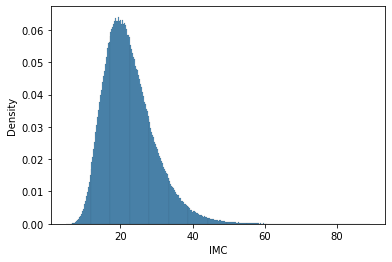

In [70]:
sns.histplot(data=ind_df_2, x='IMC', stat='density', bins=320);

In [71]:
ind_df_2.loc[ind_df_2['IMC'].isna(), 'IMC'] = (ind_df_2
                                               .loc[~ind_df_2['IMC'].isna(), 'IMC']
                                               .sample(n=ind_df_2['IMC'].isna().sum(),
                                                       replace=True,
                                                       random_state=42)
                                               .values)

In [72]:
ind_df_2['IMC'].describe().T

count    1000000.000000
mean          22.471856
std            7.073058
min            4.852828
25%           17.421579
50%           21.433476
75%           26.375954
max           89.158204
Name: IMC, dtype: float64

In [73]:
# def fit_distribution(data, d):
#     try:
#         dist = getattr(stats, d)
#     except:
#         return -1
#     param = dist.fit(data)
#     ks_res = stats.kstest(data, d, args=param)
#     return d, param, ks_res

In [74]:
# dist_continuous = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]

In [75]:
# %%time

# res_imc = [fit_distribution(ind_df_2['IMC'].dropna(), d) for d in tqdm(dist_continuous)]

In [76]:
# res_imc.sort(key=lambda x: x[1].statistic, reverse=True)
# for r in res_imc[:10]:
#     print(f'{r[0]}: statistic={r[1].statistic}, pvalue={r[1].pvalue}')

In [77]:
# %%time

# res_idade = [fit_distribution(ind_df_2['idade'].dropna(), d) for d in tqdm(dist_continuous)]

In [78]:
# res_idade.sort(key=lambda x: x[1].statistic, reverse=True)
# for r in res_idade[:10]:
#     print(f'{r[0]}: statistic={r[1].statistic}, pvalue={r[1].pvalue}')

In [79]:
ind_df_2.isna().sum()

name                         0
idade                        0
estado_civil                 0
qt_filhos                    0
estuda                       0
trabalha                     0
pratica_esportes             0
transporte_mais_utilizado    0
IMC                          0
idade_16mais                 0
dtype: int64

### Feature engineering `ind_df`

### Feature engineering `conn_df`

### Treinamento

Uma vez com `ind_df` completo, o combinamos com `conn_df` e procedemos com a redução da dimensionalidade com o método PCA, reduzindo o número de features, agora, de 31 para 18, seguido da imputação dos missing values no target com o KNN Regressor, como discutido anteriormente. Desta vez, no entanto, diferentemente do que ocorreu com o Modelo 1, o processo de imputação nesta segunda etapa levou cerca de 2 horas e 30 minutos. Ainda asssim, mesmo considerando o tempo gasto com toda a parte de EDA para completar `ind_df`, a estratégia de imputação utilizada no Modelo 2 teve uma duração total consideravelmente menor que aquela utilizada no Modelo 1, e como veremos abaixo, obtendo ainda uma taxa de performance apenas ligeiramente inferior.

In [80]:
df_2 = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V2'),
                conn_df, 
                how='right',
                left_on='name_V2', 
                right_on='V2')
df_2 = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V1'),
                df_2, 
                how='right',
                left_on='name_V1', 
                right_on='V1')
df_2 = df_2.drop(['V1', 'V2'], axis=1)
df_2

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,idade_16mais_V1,...,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,idade_16mais_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,True,...,0.0,0.0,1.0,1.0,publico,25.378720,True,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,True,...,1.0,0.0,1.0,1.0,particular,19.952393,True,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,True,...,1.0,1.0,1.0,0.0,publico,26.732053,True,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,True,...,2.0,1.0,1.0,1.0,publico,15.295668,True,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,1.0,1.0,particular,19.952393,True,...,1.0,0.0,1.0,0.0,publico,20.412942,True,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,True,...,1.0,0.0,1.0,1.0,publico,17.556771,True,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,True,...,1.0,0.0,1.0,1.0,particular,24.848402,True,trabalho,visita_rara,NaN
999996,499999,26.0,casado,2.0,0.0,1.0,0.0,taxi,19.543889,True,...,1.0,0.0,1.0,1.0,publico,23.829635,True,familia,visita_casual,0.451662
999997,499999,26.0,casado,2.0,0.0,1.0,0.0,taxi,19.543889,True,...,0.0,1.0,1.0,1.0,publico,16.979569,True,familia,visita_rara,0.186973


In [81]:
scaler = MinMaxScaler()
pca = PCA(n_components=0.9, random_state=42)

df_2_ = pd.get_dummies(df_2.drop(cols_to_drop, axis=1), drop_first=True)
df_2_ = pca.fit_transform(scaler.fit_transform(df_2_))
pca_comps = [f'pc_{n+1}' for n in range(df_2_.shape[1])]
df_2_ = pd.DataFrame(scaler.fit_transform(df_2_), columns=pca_comps)

pd.Series(pca.explained_variance_ratio_, index=pca_comps).cumsum()

pc_1     0.088878
pc_2     0.177528
pc_3     0.250166
pc_4     0.321781
pc_5     0.393259
pc_6     0.462724
pc_7     0.511734
pc_8     0.560547
pc_9     0.608695
pc_10    0.651247
pc_11    0.693758
pc_12    0.731004
pc_13    0.765220
pc_14    0.794586
pc_15    0.821275
pc_16    0.847517
pc_17    0.873007
pc_18    0.896136
pc_19    0.911570
dtype: float64

In [82]:
df_2_ = df_2_.loc[:, :pca_comps[-1]]
df_2_['prob_V1_V2'] = df_2['prob_V1_V2']

df_2_

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19,prob_V1_V2
0,0.427991,0.006559,0.654852,0.306721,0.534025,0.020171,0.279216,0.772966,0.927679,0.391401,0.019789,0.552115,0.579396,0.074768,0.809644,0.508176,0.443054,0.061208,0.248366,0.589462
1,0.009195,0.573104,0.085026,0.427045,0.460886,0.027389,0.059448,0.795704,0.295572,0.385053,0.021340,0.391109,0.605081,0.365242,0.780743,0.296098,0.441220,0.057659,0.214352,0.708465
2,0.425488,0.005970,0.913576,0.332619,0.377322,0.026082,0.689968,0.454934,0.123023,0.979961,0.389242,0.228351,0.660242,0.304157,0.292905,0.581943,0.324715,0.059497,0.243717,NaN
3,0.426282,0.005922,0.056258,0.451253,0.314124,0.035233,0.439712,0.390122,0.229294,0.384060,0.019850,0.071523,0.692132,0.596514,0.263497,0.368808,0.325293,0.055255,0.246052,0.638842
4,0.992256,0.425436,0.589516,0.296660,0.614342,0.492263,0.442779,0.132470,0.343834,0.979490,0.383572,0.443872,0.412962,0.334601,0.498558,0.618410,0.292492,0.975450,0.253022,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,0.430501,0.007202,0.117972,0.274780,0.595813,0.018704,0.315329,0.678307,0.291955,0.018893,0.611376,0.439720,0.443216,0.298633,0.246575,0.581625,0.266590,0.058033,0.246966,NaN
999995,0.011926,0.573562,0.117988,0.271129,0.594702,0.017501,0.314439,0.679058,0.291588,0.016070,0.611424,0.439003,0.443902,0.298493,0.246474,0.580702,0.266081,0.057126,0.213162,NaN
999996,0.727961,0.224388,0.951919,0.106772,0.456029,0.963651,0.537698,0.376707,0.099181,0.013702,0.612243,0.526539,0.325413,0.356890,0.467139,0.093167,0.540002,0.047361,0.041245,0.451662
999997,0.727690,0.226740,0.079368,0.295793,0.346277,0.977369,0.719500,0.397040,0.259233,0.013999,0.611808,0.295904,0.342991,0.084316,0.532138,0.571752,0.545736,0.048475,0.040336,0.186973


In [83]:
df_2_.describe().T

,count,mean,std,min,25%,50%,75%,max
pc_1,999999.0,0.482679,0.326119,0.000000,0.298539,0.426338,0.723535,1.000000
pc_2,999999.0,0.383164,0.324831,0.000000,0.008925,0.423377,0.574056,1.000000
pc_3,999999.0,0.494209,0.352352,0.000000,0.105876,0.584415,0.886856,1.000000
pc_4,999999.0,0.415945,0.179629,0.000000,0.284085,0.398143,0.527934,1.000000
pc_5,999999.0,0.481340,0.177830,0.000000,0.358050,0.469238,0.596070,1.000000
pc_6,999999.0,0.498435,0.385606,0.000000,0.031918,0.497830,0.964192,1.000000
pc_7,999999.0,0.461159,0.203953,0.000000,0.330944,0.459935,0.612457,1.000000
pc_8,999999.0,0.452589,0.196813,0.000000,0.318977,0.452164,0.600016,1.000000
pc_9,999999.0,0.346779,0.270337,0.000000,0.156074,0.252989,0.415964,1.000000
pc_10,999999.0,0.475940,0.317010,0.000000,0.246385,0.388871,0.625941,1.000000


In [84]:
mask = df_2_['prob_V1_V2'].isna()
X_2_isna = df_2_.loc[mask].drop('prob_V1_V2', axis=1)
X_2_notna = df_2_.loc[~mask].drop('prob_V1_V2', axis=1)
y_2_notna = logit(df_2_.loc[~mask, 'prob_V1_V2'])

In [85]:
# %%time

# knn_reg_imp = KNeighborsRegressor(weights='distance', n_jobs=-1)

# knn_reg_imp.fit(X_2_notna, y_2_notna)

# df_2_.loc[mask, 'prob_V1_V2'] = sigmoid(knn_reg_imp.predict(X_2_isna))

In [86]:
# df_2['prob_V1_V2'] = df_2_['prob_V1_V2']
df_2['prob_V1_V2'] = pd.read_csv('../data/processed/df_2_prob_V1_V2_filled_knn.csv')

X_2_, y_2 = df_2.drop(cols_to_drop, axis=1), df_2['prob_V1_V2']
X_2 = pd.get_dummies(X_2_, drop_first=True)

In [87]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2,
                                                            logit(y_2),
                                                            test_size=0.4,
                                                            random_state=42)

lr_2_model = LinearRegression().fit(X_2_train, y_2_train)

In [88]:
train_loss = cross_entropy_loss(y_2_train, lr_2_model.predict(X_2_train))
test_loss = cross_entropy_loss(y_2_test, lr_2_model.predict(X_2_test))

print('lr_2 train loss:', train_loss)
print('lr_2 test loss:', test_loss)

lr_2 train loss: 0.6652066136499467
lr_2 test loss: 0.6652915958126561


## LightGBM Regressor

Esta estratégia, dentre todas as utilizadas, é certamente a mais eficiente, pois não há necessidade de se preocupar em imputar os missing values. E mais do que isso, é um modelo que utiliza o fato de que existem missing values como informação para o treinamento e otimização da performance. Entretanto, trata-se de um modelo altamente complexo e de difícil interpretação.

In [89]:
df_3 = pd.get_dummies(df_raw.drop(['name_V1', 'name_V2'], axis=1), drop_first=True)
X_3, y_3 = df_3.drop('prob_V1_V2', axis=1), df_3['prob_V1_V2']
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3,
                                                            logit(y_3),
                                                            test_size=0.4,
                                                            random_state=42)

In [90]:
lgbm_reg = lgb.LGBMRegressor(random_state=42)
lgbm_reg.fit(X_3_train, y_3_train);

In [91]:
train_loss = cross_entropy_loss(y_3_train, lgbm_reg.predict(X_3_train))
test_loss = cross_entropy_loss(y_3_test, lgbm_reg.predict(X_3_test))

print('lgbr train loss:', train_loss)
print('lgbr test loss:', test_loss)

lgbr train loss: 0.6489607855872174
lgbr test loss: 0.6490465650369334


# Estimando a taxa de contaminação para o resto da população

Feitas todas as considerações acima, optamos pela utilização do Modelo 2 por se tratar do melhor meio-termo quando ponderados os fatores: interpretabilidade, custo de modelagem e performance.

In [92]:
df_half = df_2.copy(deep=True)

In [93]:
df_half

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,idade_16mais_V1,...,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,idade_16mais_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,True,...,0.0,0.0,1.0,1.0,publico,25.378720,True,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,True,...,1.0,0.0,1.0,1.0,particular,19.952393,True,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,True,...,1.0,1.0,1.0,0.0,publico,26.732053,True,trabalho,visita_casual,0.639391
3,2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,True,...,2.0,1.0,1.0,1.0,publico,15.295668,True,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,1.0,1.0,particular,19.952393,True,...,1.0,0.0,1.0,0.0,publico,20.412942,True,amigos,mora_junto,0.331446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,True,...,1.0,0.0,1.0,1.0,publico,17.556771,True,trabalho,visita_rara,0.404732
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,True,...,1.0,0.0,1.0,1.0,particular,24.848402,True,trabalho,visita_rara,0.511729
999996,499999,26.0,casado,2.0,0.0,1.0,0.0,taxi,19.543889,True,...,1.0,0.0,1.0,1.0,publico,23.829635,True,familia,visita_casual,0.451662
999997,499999,26.0,casado,2.0,0.0,1.0,0.0,taxi,19.543889,True,...,0.0,1.0,1.0,1.0,publico,16.979569,True,familia,visita_rara,0.186973


In [94]:
rev_cols = ['V2', 'V1', 'grau', 'proximidade']
rev_conn_df = conn_df[rev_cols].copy(deep=True).rename(columns={'V1': 'V2', 'V2': 'V1'})
rev_conn_df['prob_V1_V2'] = np.nan

In [95]:
df_other_half = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V2'),
                         rev_conn_df, 
                         how='right',
                         left_on='name_V2', 
                         right_on='V2')
df_other_half = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V1'),
                         df_other_half, 
                         how='right',
                         left_on='name_V1', 
                         right_on='V1')
df_other_half = df_other_half.drop(['V1', 'V2'], axis=1)

df_other_half

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,idade_16mais_V1,...,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,idade_16mais_V2,grau,proximidade,prob_V1_V2
0,2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,True,...,1.0,1.0,0.0,1.0,publico,22.200956,True,trabalho,visita_frequente,NaN
1,3,35.0,solteiro,1.0,0.0,1.0,1.0,particular,19.952393,True,...,1.0,1.0,0.0,1.0,publico,22.200956,True,trabalho,visita_rara,NaN
2,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053,True,...,0.0,0.0,1.0,1.0,publico,25.378720,True,trabalho,visita_casual,NaN
3,5,30.0,solteiro,2.0,1.0,1.0,1.0,publico,15.295668,True,...,0.0,0.0,1.0,1.0,publico,25.378720,True,trabalho,visita_rara,NaN
4,6,20.0,outros,1.0,0.0,1.0,0.0,publico,20.412942,True,...,1.0,0.0,1.0,1.0,particular,19.952393,True,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771,True,...,0.0,1.0,1.0,0.0,publico,22.036885,True,trabalho,visita_rara,NaN
999995,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402,True,...,0.0,1.0,1.0,0.0,publico,22.036885,True,trabalho,visita_rara,NaN
999996,999998,30.0,divorciado,1.0,0.0,1.0,1.0,publico,23.829635,True,...,2.0,0.0,1.0,0.0,taxi,19.543889,True,familia,visita_casual,NaN
999997,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569,True,...,2.0,0.0,1.0,0.0,taxi,19.543889,True,familia,visita_rara,NaN


In [96]:
X_other_half_ = df_other_half.drop(cols_to_drop, axis=1)
X_other_half = pd.get_dummies(X_other_half_, drop_first=True)

In [97]:
# lr_model = joblib.load('../data/processed/lr_2_model.pkl')
lr_model = lr_2_model

In [98]:
df_other_half['prob_V1_V2'] = sigmoid(lr_model.predict(X_other_half))

In [99]:
df_other_half

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,idade_16mais_V1,...,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,idade_16mais_V2,grau,proximidade,prob_V1_V2
0,2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,True,...,1.0,1.0,0.0,1.0,publico,22.200956,True,trabalho,visita_frequente,0.543718
1,3,35.0,solteiro,1.0,0.0,1.0,1.0,particular,19.952393,True,...,1.0,1.0,0.0,1.0,publico,22.200956,True,trabalho,visita_rara,0.410131
2,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053,True,...,0.0,0.0,1.0,1.0,publico,25.378720,True,trabalho,visita_casual,0.534352
3,5,30.0,solteiro,2.0,1.0,1.0,1.0,publico,15.295668,True,...,0.0,0.0,1.0,1.0,publico,25.378720,True,trabalho,visita_rara,0.465517
4,6,20.0,outros,1.0,0.0,1.0,0.0,publico,20.412942,True,...,1.0,0.0,1.0,1.0,particular,19.952393,True,amigos,mora_junto,0.387707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771,True,...,0.0,1.0,1.0,0.0,publico,22.036885,True,trabalho,visita_rara,0.505992
999995,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402,True,...,0.0,1.0,1.0,0.0,publico,22.036885,True,trabalho,visita_rara,0.483047
999996,999998,30.0,divorciado,1.0,0.0,1.0,1.0,publico,23.829635,True,...,2.0,0.0,1.0,0.0,taxi,19.543889,True,familia,visita_casual,0.598358
999997,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569,True,...,2.0,0.0,1.0,0.0,taxi,19.543889,True,familia,visita_rara,0.470456


In [100]:
df = df_half.append(df_other_half, ignore_index=True).drop(['name_V1', 'name_V2'], axis=1)

cols = ['idade_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
        'idade_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

df[cols] = df[cols].round()

df

,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,idade_16mais_V1,idade_V2,...,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,idade_16mais_V2,grau,proximidade,prob_V1_V2
0,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,True,24.0,...,0.0,0.0,1.0,1.0,publico,25.378720,True,trabalho,visita_frequente,0.589462
1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,True,35.0,...,1.0,0.0,1.0,1.0,particular,19.952393,True,trabalho,visita_rara,0.708465
2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,True,50.0,...,1.0,1.0,1.0,0.0,publico,26.732053,True,trabalho,visita_casual,0.639391
3,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,True,30.0,...,2.0,1.0,1.0,1.0,publico,15.295668,True,trabalho,visita_rara,0.638842
4,35.0,solteiro,1.0,0.0,1.0,1.0,particular,19.952393,True,20.0,...,1.0,0.0,1.0,0.0,publico,20.412942,True,amigos,mora_junto,0.331446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999993,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771,True,23.0,...,0.0,1.0,1.0,0.0,publico,22.036885,True,trabalho,visita_rara,0.505992
1999994,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402,True,23.0,...,0.0,1.0,1.0,0.0,publico,22.036885,True,trabalho,visita_rara,0.483047
1999995,30.0,divorciado,1.0,0.0,1.0,1.0,publico,23.829635,True,26.0,...,2.0,0.0,1.0,0.0,taxi,19.543889,True,familia,visita_casual,0.598358
1999996,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569,True,26.0,...,2.0,0.0,1.0,0.0,taxi,19.543889,True,familia,visita_rara,0.470456


## Feature importance

In [101]:
scaler = StandardScaler()

xentropy_loss = make_scorer(cross_entropy_loss, greater_is_better=False)

feats_imp = permutation_importance(lr_model,
                                   scaler.fit_transform(X_2_train),
                                   y_2_train,
                                   scoring=xentropy_loss,
                                   n_jobs=-1,
                                   random_state=42)

In [102]:
coefs_imp = (pd.
             DataFrame({'coefs': X_2_train.columns,
                        'avg_imp': feats_imp.importances_mean,
                        'std_imp': feats_imp.importances_std})
             .sort_values('avg_imp', ascending=False, ignore_index=True))

coefs_imp

,coefs,avg_imp,std_imp
0,proximidade_visita_casual,9.734052e-02,8.434308e-05
1,proximidade_visita_frequente,3.459722e-02,7.713394e-05
2,pratica_esportes_V1,3.102143e-02,1.078319e-04
3,proximidade_visita_rara,2.620231e-02,1.219706e-05
4,estado_civil_V1_viuvo,1.448941e-02,1.016882e-04
5,grau_familia,1.443991e-02,4.007338e-05
6,estado_civil_V1_solteiro,1.392090e-02,4.253834e-05
7,trabalha_V1,1.345469e-02,6.960272e-05
8,transporte_mais_utilizado_V2_particular,5.736859e-03,3.780558e-05
9,estado_civil_V1_outros,1.150903e-03,1.424286e-05


## EDA

In [103]:
prob_mean = df['prob_V1_V2'].mean()
prob_std = df['prob_V1_V2'].std()

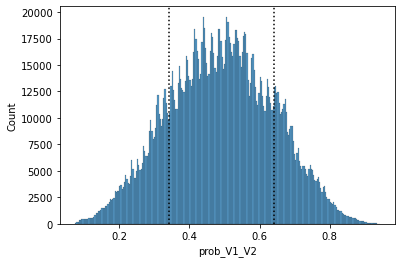

In [104]:
sns.histplot(x='prob_V1_V2', data=df)
plt.axvline(prob_mean - prob_std, color='black', linestyle=':')
plt.axvline(prob_mean + prob_std, color='black', linestyle=':');

In [105]:
prob_mean = df['prob_V1_V2'].mean()
prob_std = df['prob_V1_V2'].std()

df['risco_contaminacao'] = 1
df.loc[df['prob_V1_V2'] < prob_mean - prob_std, 'risco_contaminacao'] = 0
df.loc[df['prob_V1_V2'] > prob_mean + prob_std, 'risco_contaminacao'] = 2

In [106]:
df['risco_contaminacao'].value_counts(normalize=True)

1    0.654047
2    0.175030
0    0.170923
Name: risco_contaminacao, dtype: float64

In [107]:
df.groupby('risco_contaminacao').apply(lambda x: x.describe().T)

count       mean        std  \
risco_contaminacao                                                        
0                  idade_V1              341845.0  30.715163  10.573885   
                   qt_filhos_V1          341845.0   0.865568   0.780906   
                   estuda_V1             341845.0   0.358680   0.479614   
                   trabalha_V1           341845.0   0.915520   0.278106   
                   pratica_esportes_V1   341845.0   0.373204   0.483656   
                   IMC_V1                341845.0  22.446989   7.077374   
                   idade_V2              341845.0  30.185894  10.992934   
                   qt_filhos_V2          341845.0   0.834919   0.782651   
                   estuda_V2             341845.0   0.425500   0.494419   
                   trabalha_V2           341845.0   0.777809   0.415720   
                   pratica_esportes_V2   341845.0   0.661920   0.473057   
                   IMC_V2                341845.0  22.301038   6.979124   
                   prob_V1_V2            341845.0   0.268987   0.056630   
                   risco_contaminacao    341845.0   0.000000   0.000000   
1                  idade_V1             1308093.0  30.043070  10.948547   
                   qt_filhos_V1         1308093.0   0.837602   0.783867   
                   estuda_V1            1308093.0   0.424327   0.494241   
                   trabalha_V1          1308093.0   0.791571   0.406185   
                   pratica_esportes_V1  1308093.0   0.672649   0.469247   
                   IMC_V1               1308093.0  22.466247   7.070489   
                   idade_V2             1308093.0  30.007840  10.972227   
                   qt_filhos_V2         1308093.0   0.836426   0.783982   
                   estuda_V2            1308093.0   0.427762   0.494754   
                   trabalha_V2          1308093.0   0.789311   0.407798   
                   pratica_esportes_V2  1308093.0   0.658862   0.474092   
                   IMC_V2               1308093.0  22.455821   7.078662   
                   prob_V1_V2           1308093.0   0.489838   0.081084   
                   risco_contaminacao   1308093.0   1.000000   0.000000   
2                  idade_V1              350060.0  29.101660  11.336566   
                   qt_filhos_V1          350060.0   0.797563   0.784869   
                   estuda_V1             350060.0   0.506910   0.499953   
                   trabalha_V1           350060.0   0.628735   0.483144   
                   pratica_esportes_V1   350060.0   0.890619   0.312117   
                   IMC_V1                350060.0  22.492618   7.090018   
                   idade_V2              350060.0  29.750154  10.907319   
                   qt_filhos_V2          350060.0   0.831886   0.784220   
                   estuda_V2             350060.0   0.428824   0.494909   
                   trabalha_V2           350060.0   0.771662   0.419762   
                   pratica_esportes_V2   350060.0   0.660195   0.473643   
                   IMC_V2                350060.0  22.674105   7.149524   
                   prob_V1_V2            350060.0   0.710042   0.056435   
                   risco_contaminacao    350060.0   2.000000   0.000000   

                                             min        25%        50%  \
risco_contaminacao                                                       
0                  idade_V1             1.000000  23.000000  29.000000   
                   qt_filhos_V1         0.000000   0.000000   1.000000   
                   estuda_V1            0.000000   0.000000   0.000000   
                   trabalha_V1          0.000000   1.000000   1.000000   
                   pratica_esportes_V1  0.000000   0.000000   0.000000   
                   IMC_V1               5.376728  17.386995  21.397280   
                   idade_V2             1.000000  22.000000  29.000000   
                   qt_filhos_V2         0.000000   0.000000   1.000000   
   

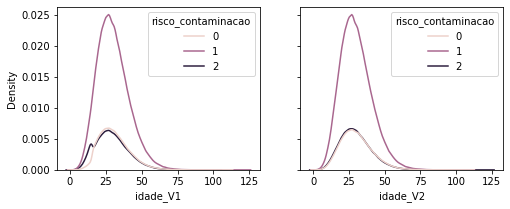

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

sns.kdeplot(x='idade_V1', data=df, hue='risco_contaminacao', ax=ax[0])
sns.kdeplot(x='idade_V2', data=df, hue='risco_contaminacao', ax=ax[1]);

In [109]:
df['idade_V1_cat'] = '16_mais'
df.loc[df['idade_V1'] < 16, 'idade_V1_cat'] = 'ate_16'

cols = ['estado_civil_V1', 'estado_civil_V2', 'qt_filhos_V1', 'qt_filhos_V2',
        'estuda_V1', 'estuda_V2', 'trabalha_V1', 'trabalha_V2', 'pratica_esportes_V1',
        'pratica_esportes_V2', 'transporte_mais_utilizado_V1', 'transporte_mais_utilizado_V2']

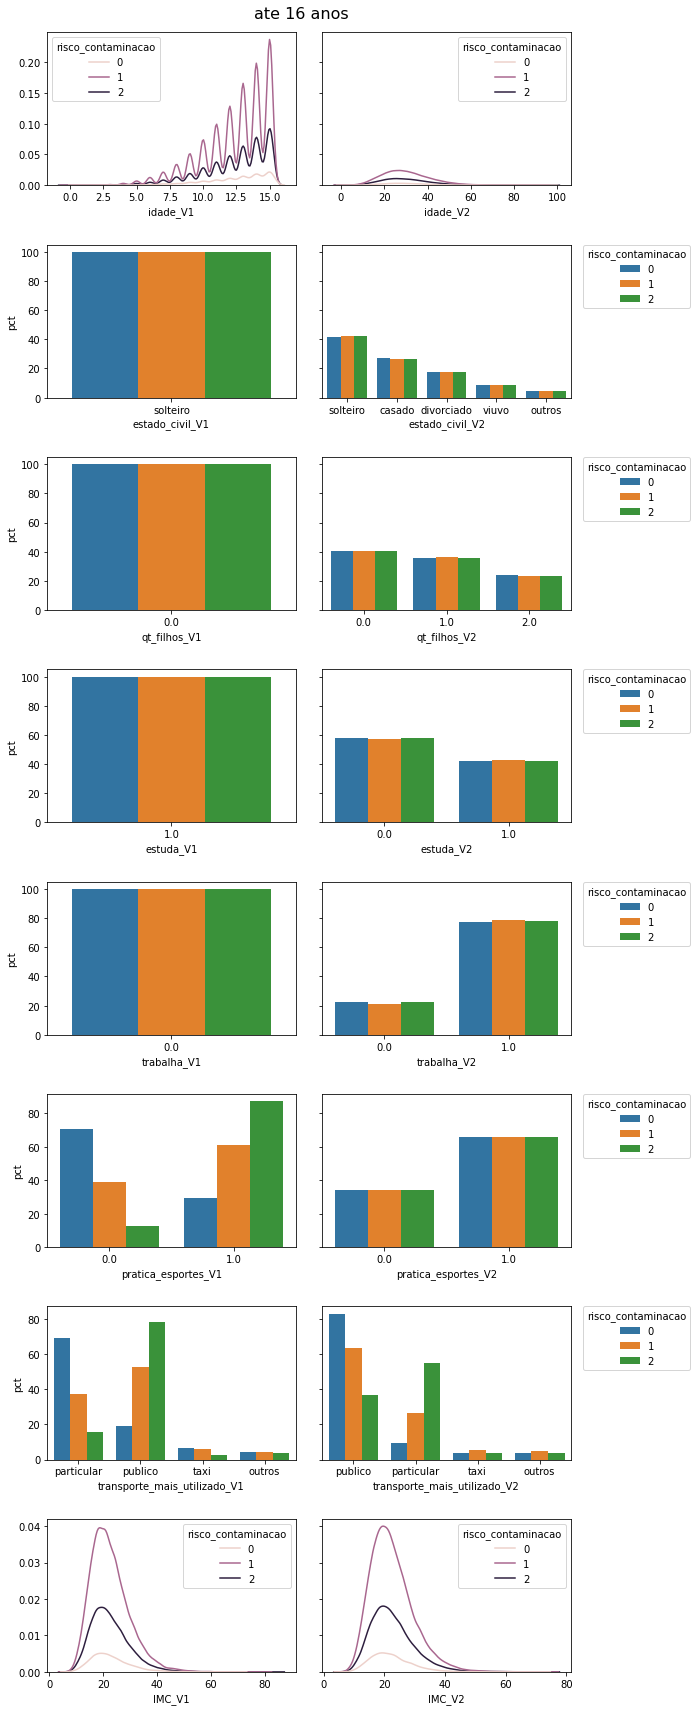

In [120]:
fig, ax = plt.subplots(8, 2, figsize=(8, 24), sharey='row')
fig.tight_layout(h_pad=4)
fig.subplots_adjust(top=0.965)
fig.suptitle('ate 16 anos', fontsize=16)

sns.kdeplot(x='idade_V1', data=df.query('idade_V1_cat == "ate_16"'), hue='risco_contaminacao', ax=ax[0, 0])
ax[0, 0].set_ylabel('')
sns.kdeplot(x='idade_V2', data=df.query('idade_V1_cat == "ate_16"'), hue='risco_contaminacao', ax=ax[0, 1])
ax[0, 1].set_ylabel('')

for n, c in enumerate(cols, start=2):
    if n%2 == 0:
        tmp = (df
               .query('idade_V1_cat == "ate_16"')
               .groupby('risco_contaminacao')[c]
               .value_counts(normalize=True)
               .mul(100)
               .rename('pct')
               .reset_index())
        
        sns.barplot(x=c, y='pct', data=tmp, hue='risco_contaminacao', ax=ax[n//2, n%2])
        ax[n//2, n%2].get_legend().remove()
        
    elif n%2 == 1:
        tmp = (df
               .query('idade_V1_cat == "ate_16"')
               .groupby('risco_contaminacao')[c]
               .value_counts(normalize=True)
               .mul(100)
               .rename('pct')
               .reset_index())
        
        sns.barplot(x=c, y='pct', data=tmp, hue='risco_contaminacao', ax=ax[n//2, n%2])
        ax[n//2, n%2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='risco_contaminacao')
        ax[n//2, n%2].set_ylabel('')
        
sns.kdeplot(x='IMC_V1', data=df.query('idade_V1_cat == "ate_16"'), hue='risco_contaminacao', ax=ax[7, 0])
ax[7, 0].set_ylabel('')
sns.kdeplot(x='IMC_V2', data=df.query('idade_V1_cat == "ate_16"'), hue='risco_contaminacao', ax=ax[7, 1])
ax[7, 1].set_ylabel('');

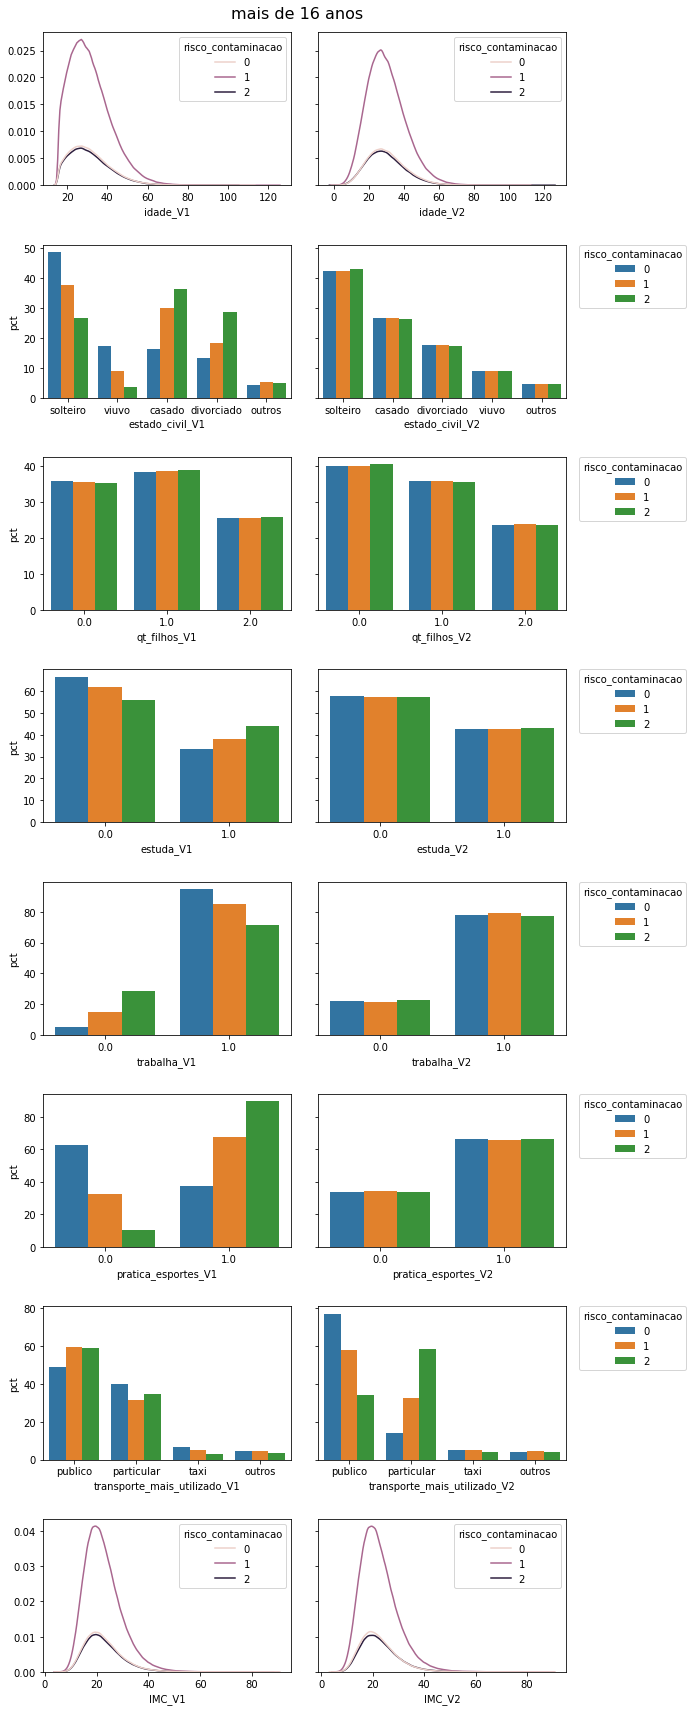

In [121]:
fig, ax = plt.subplots(8, 2, figsize=(8, 24), sharey='row')
fig.tight_layout(h_pad=4)
fig.subplots_adjust(top=0.965)
fig.suptitle('mais de 16 anos', fontsize=16)

sns.kdeplot(x='idade_V1', data=df.query('idade_V1_cat == "16_mais"'), hue='risco_contaminacao', ax=ax[0, 0])
ax[0, 0].set_ylabel('')
sns.kdeplot(x='idade_V2', data=df.query('idade_V1_cat == "16_mais"'), hue='risco_contaminacao', ax=ax[0, 1])
ax[0, 1].set_ylabel('')

for n, c in enumerate(cols, start=2):
    if n%2 == 0:
        tmp = (df
               .query('idade_V1_cat == "16_mais"')
               .groupby('risco_contaminacao')[c]
               .value_counts(normalize=True)
               .mul(100)
               .rename('pct')
               .reset_index())
        
        sns.barplot(x=c, y='pct', data=tmp, hue='risco_contaminacao', ax=ax[n//2, n%2])
        ax[n//2, n%2].get_legend().remove()
        
    elif n%2 == 1:
        tmp = (df
               .query('idade_V1_cat == "16_mais"')
               .groupby('risco_contaminacao')[c]
               .value_counts(normalize=True)
               .mul(100)
               .rename('pct')
               .reset_index())
        
        sns.barplot(x=c, y='pct', data=tmp, hue='risco_contaminacao', ax=ax[n//2, n%2])
        ax[n//2, n%2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='risco_contaminacao')
        ax[n//2, n%2].set_ylabel('')
        
sns.kdeplot(x='IMC_V1', data=df.query('idade_V1_cat == "16_mais"'), hue='risco_contaminacao', ax=ax[7, 0])
ax[7, 0].set_ylabel('')
sns.kdeplot(x='IMC_V2', data=df.query('idade_V1_cat == "16_mais"'), hue='risco_contaminacao', ax=ax[7, 1])
ax[7, 1].set_ylabel('');

In [112]:
df['relacao'] = df['grau'].str.cat(df['proximidade'], sep=', ')

relacao_ls = sorted(df['relacao'].unique())

df['relacao'].value_counts(normalize=True)

trabalho, visita_rara         0.133621
familia, visita_rara          0.133500
amigos, visita_rara           0.133117
familia, visita_casual        0.100040
trabalho, visita_casual       0.100022
amigos, visita_casual         0.099786
trabalho, visita_frequente    0.066716
amigos, visita_frequente      0.066485
familia, visita_frequente     0.066422
amigos, mora_junto            0.033577
familia, mora_junto           0.033524
trabalho, mora_junto          0.033189
Name: relacao, dtype: float64

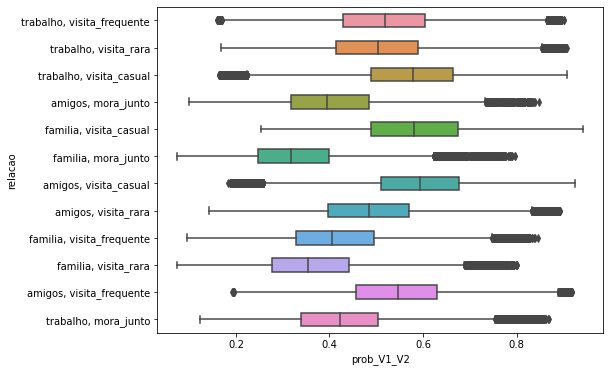

In [113]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x='prob_V1_V2', y='relacao', data=df, width=0.5);

In [114]:
relacao_2 = ['trabalho, visita_casual', 'familia, visita_casual',
             'amigos, visita_casual', 'amigos, visita_frequente']

relacao_1 = ['trabalho, visita_frequente', 'trabalho, visita_rara', 'amigos, visita_rara']

relacao_0 = ['amigos, mora_junto', 'familia, visita_frequente', 'trabalho, mora_junto',
             'familia, mora_junto', 'familia, visita_rara']

df['risco_relacao'] = 0
df.loc[df['relacao'].isin(relacao_1), 'risco_relacao'] = 1
df.loc[df['relacao'].isin(relacao_2), 'risco_relacao'] = 2

In [115]:
df['risco_relacao'].value_counts(normalize=True)

2    0.366333
1    0.333454
0    0.300212
Name: risco_relacao, dtype: float64

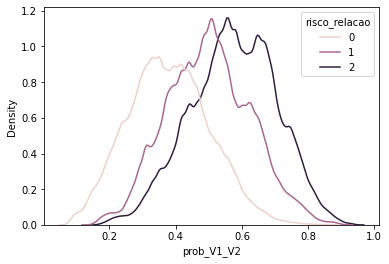

In [116]:
sns.kdeplot(x='prob_V1_V2', hue='risco_relacao', data=df);

In [117]:
df.groupby('risco_relacao').apply(lambda x: x.describe().T)

count       mean        std       min  \
risco_relacao                                                                 
0             idade_V1             600424.0  30.009307  10.961204  1.000000   
              qt_filhos_V1         600424.0   0.834202   0.784361  0.000000   
              estuda_V1            600424.0   0.428124   0.494807  0.000000   
              trabalha_V1          600424.0   0.785208   0.410678  0.000000   
              pratica_esportes_V1  600424.0   0.659899   0.473743  0.000000   
              IMC_V1               600424.0  22.462932   7.077241  4.852828   
              idade_V2             600424.0  30.009307  10.961204  1.000000   
              qt_filhos_V2         600424.0   0.834202   0.784361  0.000000   
              estuda_V2            600424.0   0.428124   0.494807  0.000000   
              trabalha_V2          600424.0   0.785208   0.410678  0.000000   
              pratica_esportes_V2  600424.0   0.659899   0.473743  0.000000   
              IMC_V2               600424.0  22.462932   7.077241  4.852828   
              prob_V1_V2           600424.0   0.379361   0.122928  0.074462   
              risco_contaminacao   600424.0   0.622602   0.524542  0.000000   
              risco_relacao        600424.0   0.000000   0.000000  0.000000   
1             idade_V1             666908.0  30.001170  10.986365  0.000000   
              qt_filhos_V1         666908.0   0.835010   0.782936  0.000000   
              estuda_V1            666908.0   0.427621   0.494734  0.000000   
              trabalha_V1          666908.0   0.784437   0.411213  0.000000   
              pratica_esportes_V1  666908.0   0.659439   0.473898  0.000000   
              IMC_V1               666908.0  22.462516   7.068992  5.534848   
              idade_V2             666908.0  30.001170  10.986365  0.000000   
              qt_filhos_V2         666908.0   0.835010   0.782936  0.000000   
              estuda_V2            666908.0   0.427621   0.494734  0.000000   
              trabalha_V2          666908.0   0.784437   0.411213  0.000000   
              pratica_esportes_V2  666908.0   0.659439   0.473898  0.000000   
              IMC_V2               666908.0  22.462516   7.068992  5.534848   
              prob_V1_V2           666908.0   0.499417   0.126052  0.142744   
              risco_contaminacao   666908.0   1.034936   0.500174  0.000000   
              risco_relacao        666908.0   1.000000   0.000000  1.000000   
2             idade_V1             732666.0  29.972667  10.949166  0.000000   
              qt_filhos_V1         732666.0   0.836665   0.784119  0.000000   
              estuda_V1            732666.0   0.427045   0.494649  0.000000   
              trabalha_V1          732666.0   0.783311   0.411990  0.000000   
              pratica_esportes_V1  732666.0   0.659552   0.473860  0.000000   
              IMC_V1               732666.0  22.475975   7.078896  5.376728   
              idade_V2             732666.0  29.972667  10.949166  0.000000   
              qt_filhos_V2         732666.0   0.836665   0.784119  0.000000   
              estuda_V2            732666.0   0.427045   0.494649  0.000000   
              trabalha_V2          732666.0   0.783311   0.411990  0.000000   
              pratica_esportes_V2  732666.0   0.659552   0.473860  0.000000   
              IMC_V2               732666.0  22.475975   7.078896  5.376728   
              prob_V1_V2           732666.0   0.573823   0.129210  0.163618   
              risco_contaminacao   732666.0   1.288692   0.538506  0.000000   
              risco_relacao        732666.0   2.000000   0.000000  2.000000   

                                         25%        50%        75%         max  
risco_relacao                                                                   
0             idade_V1             22.000000  29.000000  37.000000  111.000000  
              qt_filhos_V1          0.000000   1.000000   1.000000    2.000000  


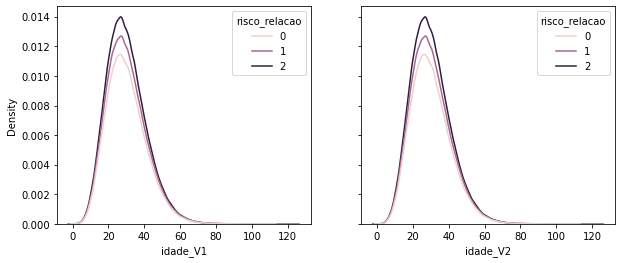

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

sns.kdeplot(x='idade_V1', data=df, hue='risco_relacao', ax=ax[0])
sns.kdeplot(x='idade_V2', data=df, hue='risco_relacao', ax=ax[1]);